Specification:
<center>"we would like to predict the number of order days in the month for each user, and
we want to be able to perform this prediction at every point of the month."</center>

- Business Problem = understand the order days for each user in a month
- Important = be able to generate predictions in all part of month window

## Used Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.arima.model import ARIMA


## Load the Data

In [2]:
df_train = pd.read_parquet('/content/historical_orders.parquet')
df_reality = pd.read_parquet('/content/august_with_missing_order_days.parquet')
df_forecast = pd.read_parquet('/content/august_total_sales.parquet')


## Data Description

In [3]:
print(df_train.shape)
print(df_train.head())

(8596877, 3)
          account_id  order_date  transaction_amount
0  BR_09607801000194  2021-08-28             11011.2
1  BR_09607801000194  2021-08-28             13764.0
2  BR_09607801000194  2021-08-28             11011.2
3  BR_09607801000194  2021-08-28             11011.2
4  BR_09607801000194  2021-08-28             13764.0


In [4]:
print(min(df_train['order_date']))
print(max(df_train['order_date']))

2021-01-02
2022-07-31


In [5]:
df_reality.head()

,account_id,order_date,transaction_amount
0,BR_09532176632,2022-08-03,11.16
1,BR_09532176632,2022-08-03,32.52
2,BR_09532176632,2022-08-03,24.90
3,BR_09532176632,2022-08-03,28.50
4,BR_09532176632,2022-08-03,11.16


In [6]:
df_forecast.head()

,account_id,total_transaction_amount_august
0,BR_00000343803,309.99
1,BR_00001415930,874.98
2,BR_00001760106,11976.70
3,BR_00002485176,511.48
4,BR_00002536340,7081.14


Dataset for trainning (df_train):

The name of columns show their meaning (account_id, order_date, transaction_amount)

## Data Cleaning

Df_train data does not includes NaN value.

In [7]:
df_train.isna().sum()

,0
account_id,0
order_date,0
transaction_amount,0


-----

## Target Definition

Target = Number of orders in *distinct* days

The main idea is an adjusting of the dataset in order to create a feature that denotes the number of orders like coutdown pattern.
Them, the model will answer as requested:

<center> "we would like our model to predict before Jan' 4th that we're expecting 2 days of orders
(prediction = 2), and after Jan' 4th (and before Jan' 25th), we would like the model to predict that there is
1 day of orders left (prediction = 1)."*" </center>

First of all, I agreggated the dataset by account_id and order_date in order to indentify order volume.

In [8]:
df_train['order_date'] = pd.to_datetime(df_train['order_date'])

df_daily = (df_train.groupby(['account_id', 'order_date'])
              .size()
              .reset_index(name='num_orders'))

df_daily['has_order'] = (df_daily['num_orders'] > 0).astype(int)

At next, the idea is the creation of target who represents the maximum value of orders and they are decreasing over month.

To do this I defined a sum of num_orders per month and year.
Then, I defined the maximum value of num_orders per day in order to define a cumulative progression.

In [9]:
#I'm creating a camp target creates the sum of orders in same month and year df_daily
df_daily['order_month'] = df_daily['order_date'].dt.to_period('M')

#I'm doing an inverse cumsum
df_daily['acumulado'] = df_daily.groupby(['account_id', 'order_month'])['num_orders'].transform('cumsum')
df_daily['max'] = df_daily.groupby(['account_id', 'order_month'])['num_orders'].transform('sum')

#I'm subtracting the max of first  with acumulado of second and so on
df_daily['target'] = df_daily['max'] - df_daily['acumulado'].shift(1)

df_daily['target'] = np.where(df_daily['target'] < 0, df_daily['max'], df_daily['target'])
df_daily['target'] = np.where(df_daily['target'].isna(), df_daily['max'], df_daily['target'])

df_daily = df_daily.drop(columns=['num_orders', 'has_order', 'acumulado', 'max', 'order_month'])

In [10]:
df_daily.head(10)

,account_id,order_date,target
0,BR_00000343803,2021-01-07,7.0
1,BR_00000343803,2021-01-14,5.0
2,BR_00000343803,2021-01-21,4.0
3,BR_00000343803,2021-01-30,2.0
4,BR_00000343803,2021-02-11,4.0
5,BR_00000343803,2021-02-18,3.0
6,BR_00000343803,2021-03-04,2.0
7,BR_00000343803,2021-03-20,2.0
8,BR_00000343803,2021-03-25,1.0
9,BR_00000343803,2021-04-15,4.0


In [11]:
df_daily.sort_values(by=['account_id', 'order_date'], inplace=True)
df_daily.head(10)

,account_id,order_date,target
0,BR_00000343803,2021-01-07,7.0
1,BR_00000343803,2021-01-14,5.0
2,BR_00000343803,2021-01-21,4.0
3,BR_00000343803,2021-01-30,2.0
4,BR_00000343803,2021-02-11,4.0
5,BR_00000343803,2021-02-18,3.0
6,BR_00000343803,2021-03-04,2.0
7,BR_00000343803,2021-03-20,2.0
8,BR_00000343803,2021-03-25,1.0
9,BR_00000343803,2021-04-15,4.0


---

## Data Exploration

Lets start with basics of visualization that is understanding data.

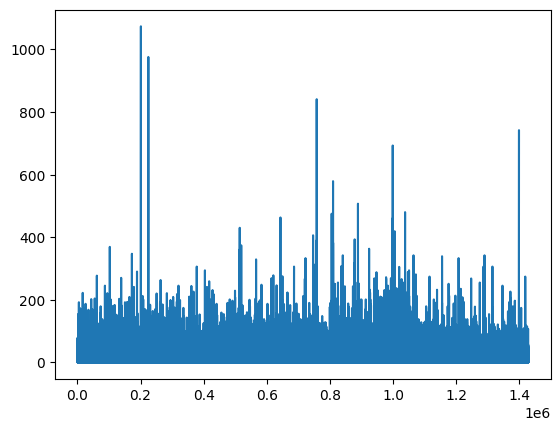

In [12]:
plt.plot(df_daily.target)

/tmp/ipython-input-3470433914.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_daily.resample('M').sum()['target'].plot()


<Axes: xlabel='order_date'>

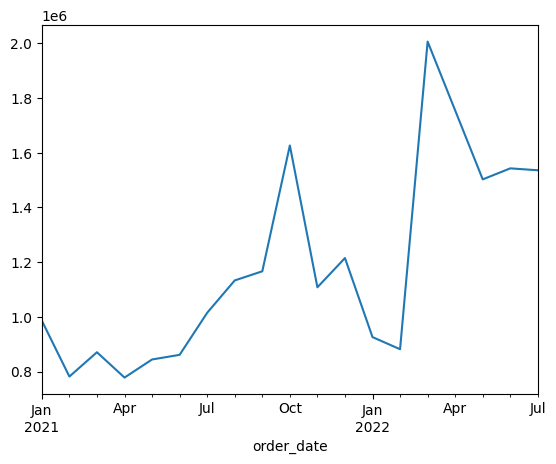

In [13]:
#checkout temporal tendecies over months
df_daily.set_index('order_date', inplace=True)
df_daily.resample('M').sum()['target'].plot()


--------

# Predicting model

I don't have too much experience in temporal predictions, but in my studies three methods have been highlited: Dynamic Bayesian Count Models, ML with Features and Hierarchical Count Models.

The chosen method was Hierarchical Bayesian Modeling because of two main reasons:
- try to be out of my confort zone and studied new strategies
- seem to be the most appropriate for my scenario. It allows you to forecast daily cumulative order days, share learning across users, handle sparsity, and update predictions as data accrues throughout the month.

Here's how to implement a Hierarchical Bayesian Model (HBM) for your df_daily dataset, where we'll model the target variable (likely representing some metric like order counts or values) with account-level partial pooling:

### 1. Data Preparation
First, let's structure the data for modeling:

In [14]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az

In [15]:
#I'm transforming index "order_date" to column order_date
df_daily['order_date'] = df_daily.index

print(df_daily)

                account_id  target order_date
order_date                                   
2021-01-07  BR_00000343803     7.0 2021-01-07
2021-01-14  BR_00000343803     5.0 2021-01-14
2021-01-21  BR_00000343803     4.0 2021-01-21
2021-01-30  BR_00000343803     2.0 2021-01-30
2021-02-11  BR_00000343803     4.0 2021-02-11
...                    ...     ...        ...
2021-05-29  BR_99980878134     4.0 2021-05-29
2021-06-07  BR_99980878134    10.0 2021-06-07
2021-06-10  BR_99980878134     8.0 2021-06-10
2021-06-12  BR_99980878134     6.0 2021-06-12
2021-06-17  BR_99980878134     5.0 2021-06-17

[1428384 rows x 3 columns]


In [16]:
print(df_daily)

#transform index "order_date" to column order_date
df_daily['order_date'] = df_daily.index

print(df_daily)

                account_id  target order_date
order_date                                   
2021-01-07  BR_00000343803     7.0 2021-01-07
2021-01-14  BR_00000343803     5.0 2021-01-14
2021-01-21  BR_00000343803     4.0 2021-01-21
2021-01-30  BR_00000343803     2.0 2021-01-30
2021-02-11  BR_00000343803     4.0 2021-02-11
...                    ...     ...        ...
2021-05-29  BR_99980878134     4.0 2021-05-29
2021-06-07  BR_99980878134    10.0 2021-06-07
2021-06-10  BR_99980878134     8.0 2021-06-10
2021-06-12  BR_99980878134     6.0 2021-06-12
2021-06-17  BR_99980878134     5.0 2021-06-17

[1428384 rows x 3 columns]
                account_id  target order_date
order_date                                   
2021-01-07  BR_00000343803     7.0 2021-01-07
2021-01-14  BR_00000343803     5.0 2021-01-14
2021-01-21  BR_00000343803     4.0 2021-01-21
2021-01-30  BR_00000343803     2.0 2021-01-30
2021-02-11  BR_00000343803     4.0 2021-02-11
...                    ...     ...        ...
2021-0

In first round, I defined two levels of observations.
 - Level 1 - target
 - Level 2 - groups of users based on their transactions in August
 - Level 3 - days

As previously attempted, working with customer IDs appears to be a very costly task in terms of computational performance.
The strategy we found was to define account groups based on the total_transaction_amount_august to see if the participation level could facilitate the model.

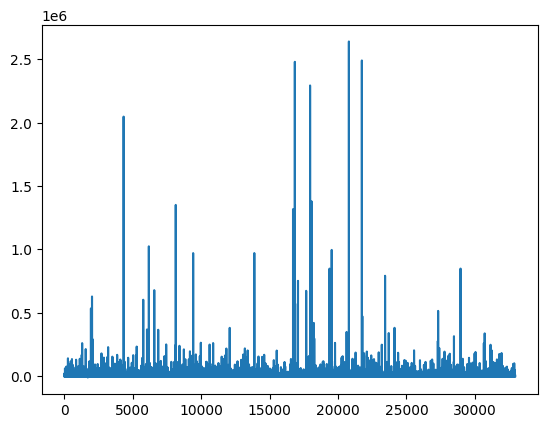

In [17]:
#I'm plotting df_forecast.total_transaction_amount_august
plt.plot(df_forecast.total_transaction_amount_august)

In [18]:
#I'm creating 5 bins based on df_forecast.total_transaction_amount_august called ['A', 'B', ..., 'E']
df_forecast['groups'] = pd.cut(df_forecast['total_transaction_amount_august'], bins=5, labels=['A', 'B', 'C', 'D', 'E'])


In [19]:
#I'm merging df_forecast with df_daily
df_merged = pd.merge(df_daily, df_forecast, on='account_id', suffixes=('_daily', '_forecast'))

In [20]:
df_merged.head()

,account_id,target,order_date,total_transaction_amount_august,groups
0,BR_00000343803,7.0,2021-01-07,309.99,A
1,BR_00000343803,5.0,2021-01-14,309.99,A
2,BR_00000343803,4.0,2021-01-21,309.99,A
3,BR_00000343803,2.0,2021-01-30,309.99,A
4,BR_00000343803,4.0,2021-02-11,309.99,A


In [21]:
# I'm sampling df_merged
df_sample = df_merged.sample(frac=0.1, random_state=42)

In [22]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az

# I'm Loading and preparing data
data = df_sample.copy()
data['order_date'] = pd.to_datetime(data['order_date'])
data['day_of_week'] = data['order_date'].dt.dayofweek

# I'm Converting to indices
group_idx, groups = pd.factorize(data['groups'])
day_idx, days = pd.factorize(data['day_of_week'])

with pm.Model() as model:
    # ---- Data Containers ----
    #group_idx_shared = pm.MutableData('group_idx', group_idx)  # Fixed typo here
    #day_idx_shared = pm.MutableData('day_idx', day_idx)

    # ---- Hyperpriors ----
    μ_global = pm.Normal("μ_global", mu=data['target'].mean(), sigma=10)
    σ_group = pm.HalfNormal("σ_group", sigma=1)
    σ_day = pm.HalfNormal("σ_day", sigma=1)

    # ---- Hierarchical Structure ----
    # Group effects (shrinkage toward global mean) - level 2
    α_group = pm.Normal("α_group", mu=μ_global, sigma=σ_group, shape=len(groups))

    # Day-of-week effects - level 3
    α_day = pm.Normal("α_day", mu=0, sigma=σ_day, shape=len(days))

    # ---- Linear Predictor ----
    μ = α_group[group_idx] + α_day[day_idx]

    # ---- Likelihood ----
    σ = pm.HalfNormal("σ", sigma=1) # Level 1
    target = pm.Normal("target", mu=μ, sigma=σ, observed=data['target'])

    # ---- Sampling ----
    trace = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        target_accept=0.9,
        random_seed=42
    )

Output()

---

In [23]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

## Analyze Results

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

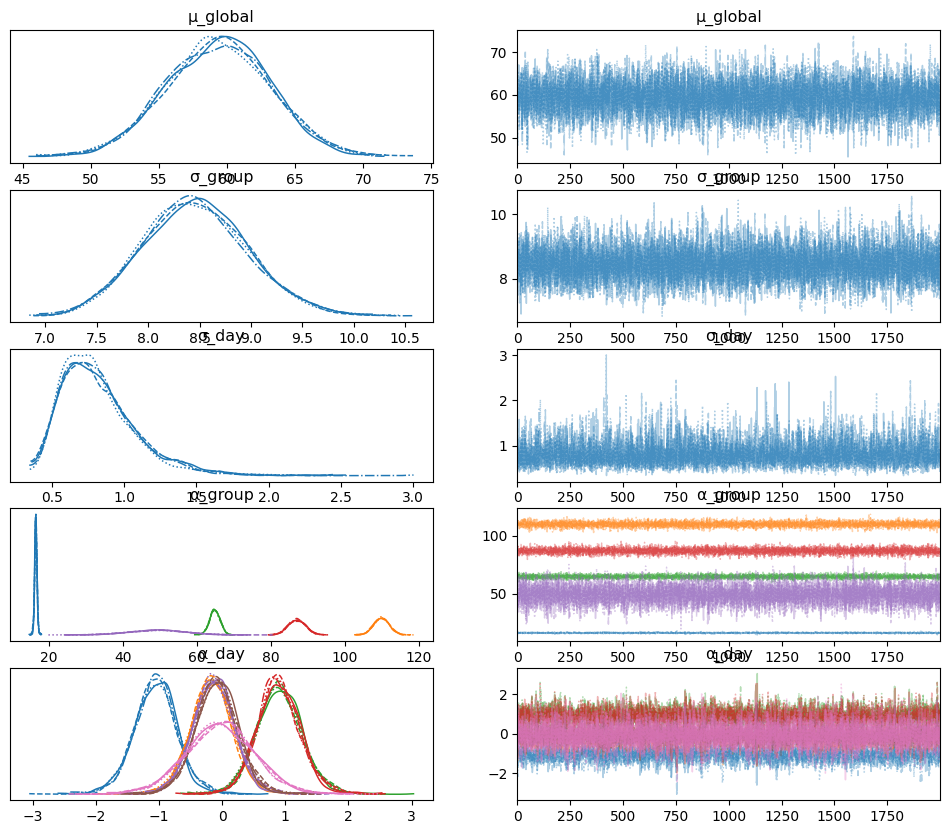

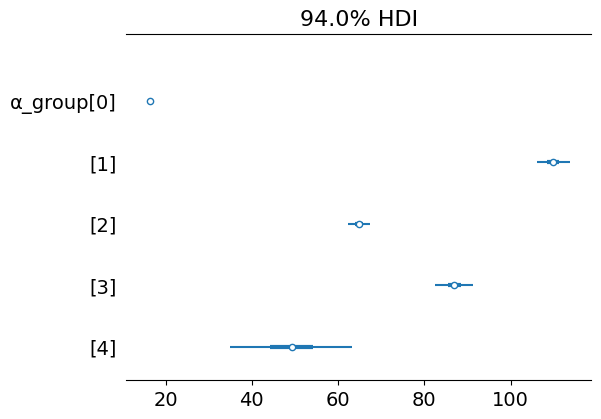

In [24]:
# Summary of key parameters
az.summary(trace, var_names=["μ_global", "σ_group", "σ_day", "α_group", "α_day"])

# I'm visualizing shrinkage
az.plot_trace(trace, var_names=["μ_global", "σ_group", "σ_day", "α_group", "α_day"])
az.plot_forest(trace, var_names=["α_group"], combined=True, hdi_prob=0.94)


## Posterior Predictive Checks
Validate if the model fits the data well:

Output()

<Axes: xlabel='target'>

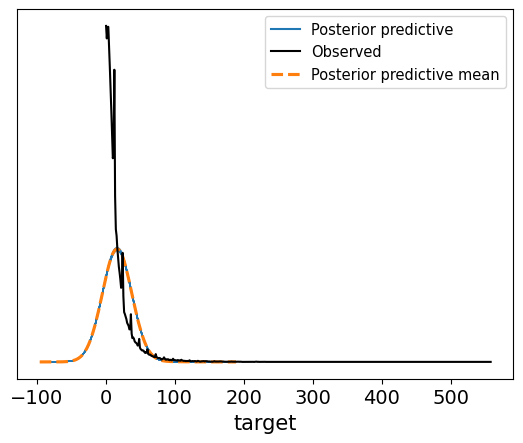

In [25]:
with model:
    ppc = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

# I'm plotting observed vs. predicted
az.plot_ppc(ppc, num_pp_samples=100)

----

# Predictions

### Preparing the dataset

In [26]:
df_reality['order_date'] = pd.to_datetime(df_reality['order_date'])

df_daily = (df_reality.groupby(['account_id', 'order_date'])
              .size()
              .reset_index(name='num_orders'))

df_daily['has_order'] = (df_daily['num_orders'] > 0).astype(int)

In [27]:
#I'm creating a camp target creates the sum of orders in same month and year df_daily
df_daily['order_month'] = df_daily['order_date'].dt.to_period('M')

#I'm doing inverse cumsum
df_daily['acumulado'] = df_daily.groupby(['account_id', 'order_month'])['num_orders'].transform('cumsum')
df_daily['max'] = df_daily.groupby(['account_id', 'order_month'])['num_orders'].transform('sum')

#I'm subtract the max of first  with acumulado of second and so on
df_daily['target'] = df_daily['max'] - df_daily['acumulado'].shift(1)

df_daily['target'] = np.where(df_daily['target'] < 0, df_daily['max'], df_daily['target'])
df_daily['target'] = np.where(df_daily['target'].isna(), df_daily['max'], df_daily['target'])

df_daily = df_daily.drop(columns=['num_orders', 'has_order', 'acumulado', 'max', 'order_month'])

In [28]:
df_daily.head(10)

,account_id,order_date,target
0,BR_00002485176,2022-08-06,7.0
1,BR_00002485176,2022-08-13,6.0
2,BR_00002536340,2022-08-02,3.0
3,BR_00009144366,2022-08-06,1.0
4,BR_00014989670,2022-08-03,44.0
5,BR_00014989670,2022-08-05,36.0
6,BR_00014989670,2022-08-06,34.0
7,BR_00014989670,2022-08-12,31.0
8,BR_00015964540,2022-08-01,14.0
9,BR_00015964540,2022-08-08,11.0


In [29]:
print(df_daily)

#I'm transforming index "order_date" to column order_date
df_daily['order_date'] = df_daily.index

print(df_daily)

           account_id order_date  target
0      BR_00002485176 2022-08-06     7.0
1      BR_00002485176 2022-08-13     6.0
2      BR_00002536340 2022-08-02     3.0
3      BR_00009144366 2022-08-06     1.0
4      BR_00014989670 2022-08-03    44.0
...               ...        ...     ...
43922  BR_99887428353 2022-08-03     9.0
43923  BR_99887428353 2022-08-08     7.0
43924  BR_99887428353 2022-08-25     4.0
43925  BR_99887428353 2022-08-26     1.0
43926  BR_99936259300 2022-08-01     2.0

[43927 rows x 3 columns]
           account_id  order_date  target
0      BR_00002485176           0     7.0
1      BR_00002485176           1     6.0
2      BR_00002536340           2     3.0
3      BR_00009144366           3     1.0
4      BR_00014989670           4    44.0
...               ...         ...     ...
43922  BR_99887428353       43922     9.0
43923  BR_99887428353       43923     7.0
43924  BR_99887428353       43924     4.0
43925  BR_99887428353       43925     1.0
43926  BR_9993625930

Doing the last adjusts

In [30]:
df_prediction = df_daily.merge(df_forecast, on='account_id', how='left')

In [31]:
df_prediction

,account_id,order_date,target,total_transaction_amount_august,groups
0,BR_00002485176,0,7.0,511.48,A
1,BR_00002485176,1,6.0,511.48,A
2,BR_00002536340,2,3.0,7081.14,A
3,BR_00009144366,3,1.0,1711.22,A
4,BR_00014989670,4,44.0,21830.93,A
...,...,...,...,...,...
43922,BR_99887428353,43922,9.0,2065.10,A
43923,BR_99887428353,43923,7.0,2065.10,A
43924,BR_99887428353,43924,4.0,2065.10,A
43925,BR_99887428353,43925,1.0,2065.10,A


In [32]:
# I'm verifying if model has the expected variables
print("Model variables:", list(model.named_vars.keys()))

# I'm being Ensure  the prediction preprocessing matches training exactly
df_prediction['order_date'] = pd.to_datetime(df_prediction['order_date'])
df_prediction['day_of_week'] = df_prediction['order_date'].dt.dayofweek

group_idx, groups = pd.factorize(df_prediction['groups'])
day_idx, days = pd.factorize(df_prediction['day_of_week'])

# I'm using the SAME categorical encoding as training
#df_prediction['groups'] = pd.Categorical(df_prediction['groups'], categories=groups)
#group_idx = df_prediction['groups'].cat.codes.to_numpy()  # numpy array
#day_idx = pd.Categorical(df_prediction['day_of_week'], categories=days).codes  # numpy array

# I'm making predictions
with model:
    #print("Data containers in model:", list(model.data_vars.keys()))

    pm.set_data({
        'group_idx': group_idx,
        'day_idx': day_idx
    })

    # Generate predictions
    posterior_predictive = pm.sample_posterior_predictive(
        trace,
        var_names=["target"],
        random_seed=42
    )

# 4. Extract predictions
preds = posterior_predictive.posterior_predictive['target'].mean(dim=("chain", "draw")).to_numpy()
print("Predictions shape:", preds.shape)
print("First 5 predictions:", preds[:5])

Model variables: ['μ_global', 'σ_group', 'σ_day', 'α_group', 'α_day', 'σ', 'target']


KeyError: 'group_idx'

In [ ]:
#do predictions with df_reality
with model:
    pm.set_data({"order_date": df_reality['order_date'], "total_transaction_amount_august": df_reality['total_transaction_amount_august']})
    posterior_predictive = pm.sample_posterior_predictive(trace)

In [ ]:
# Calculate RMAE
rmae = np.mean(np.abs(posterior_predictive['target'].mean(axis=0) - df_reality['target']) / df_reality['target'])
print(f"RMAE: {rmae:.4f}")